# Base BERT implementation

1. Import dependencies

In [1]:
import random
import time

import numpy as np
import torch
import os

from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

from src.util.torch_device import resolve_torch_device
from src.data.span_detection_ds import ManipulationDetectionDataset
from src.visualization.plot import plot_loss, plot_model_progress, plot_eval_loss
from src.definitions import (
    MODELS_FOLDER,
    RAW_DATA_FOLDER,
    REPORTS_FOLDER,
    PROCESSED_DATA_FOLDER,
)
from src.visualization.ner import visualize_as_markdown_and_save
from src.visualization.reporting import EvaluatingReport
from src.model.span_detection_metrics import compute_metrics

2. Prepare Env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

model_checkpoint = "FrinzTheCoder/bert-base-multilingual-cased-rus"

epoch_time = int(time.time())

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

3. Load dataset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

dataset_blueprint = ManipulationDetectionDataset(
    tokenizer=tokenizer,
    raw_path=RAW_DATA_FOLDER / "span-detection.parquet",
    processed_path=PROCESSED_DATA_FOLDER / "span-detection-ru",
    seed=random_seed,
    lang='ru'
)

dataset = dataset_blueprint.read()

3. Prepare model

In [4]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(dataset_blueprint.label2id),
    id2label=dataset_blueprint.id2label,
    label2id=dataset_blueprint.label2id,
).to(device)

data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir=MODELS_FOLDER / "manipulation-detector-bert-ner-ru-checkpoint",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=25,
    weight_decay=0.3,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=random_seed,
    logging_steps=100,
    auto_find_batch_size=True,
    torch_empty_cache_steps=1000,
    metric_for_best_model="f1",
    greater_is_better=True, 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics(dataset_blueprint),
)

4. Train model

In [5]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.540029,0.049231,0.087193,0.062930,0.704745
2,0.569600,0.555164,0.050360,0.057221,0.053571,0.698255
3,0.495700,0.649338,0.053299,0.057221,0.055191,0.703001
4,0.415100,0.616784,0.069421,0.114441,0.086420,0.718353
5,0.357700,0.748799,0.055188,0.068120,0.060976,0.702163
6,0.278100,0.671914,0.063866,0.103542,0.079002,0.724006
7,0.234300,0.764436,0.061706,0.092643,0.074074,0.722889
8,0.190500,0.914759,0.065263,0.084469,0.073634,0.707606
9,0.184100,0.891741,0.055877,0.079019,0.065463,0.710328
10,0.159500,0.845971,0.069808,0.108992,0.085106,0.722470


TrainOutput(global_step=2375, training_loss=0.17414763470699912, metrics={'train_runtime': 3510.7594, 'train_samples_per_second': 10.76, 'train_steps_per_second': 0.676, 'total_flos': 8765159387436108.0, 'train_loss': 0.17414763470699912, 'epoch': 25.0})

In [6]:
evaluation_feedback = trainer.evaluate()

In [7]:
report_file = REPORTS_FOLDER / "span-detection-ru" / "train-report.csv"

report = EvaluatingReport(report_file)

report.write_to_report(evaluation_feedback, epoch_time)

full_report = report.read_report()

full_report.tail(1)

,timestamp,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
1,1739302775,1.206563,0.081315,0.128065,0.099471,0.732659,3.3747,48.596,6.223,25.0


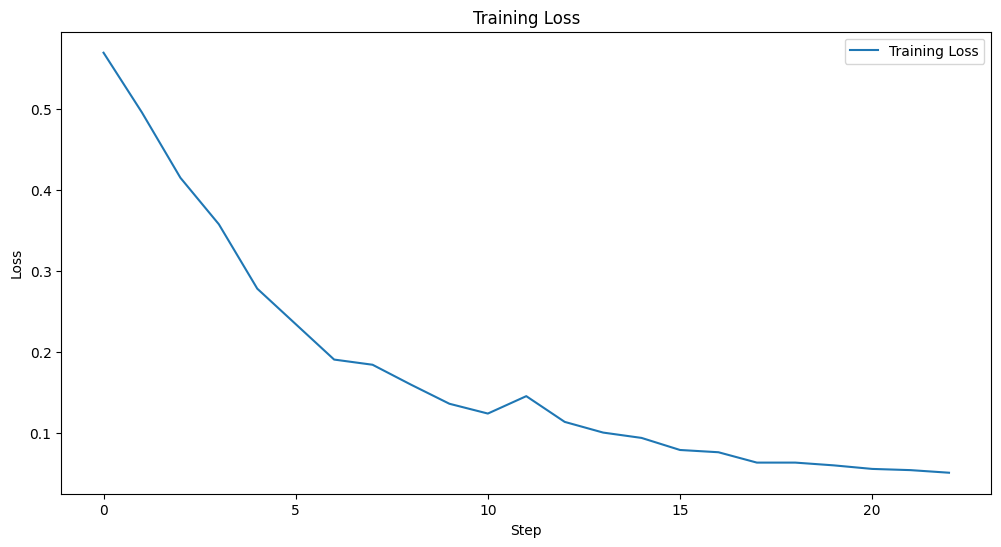

In [8]:
plot_loss(trainer)

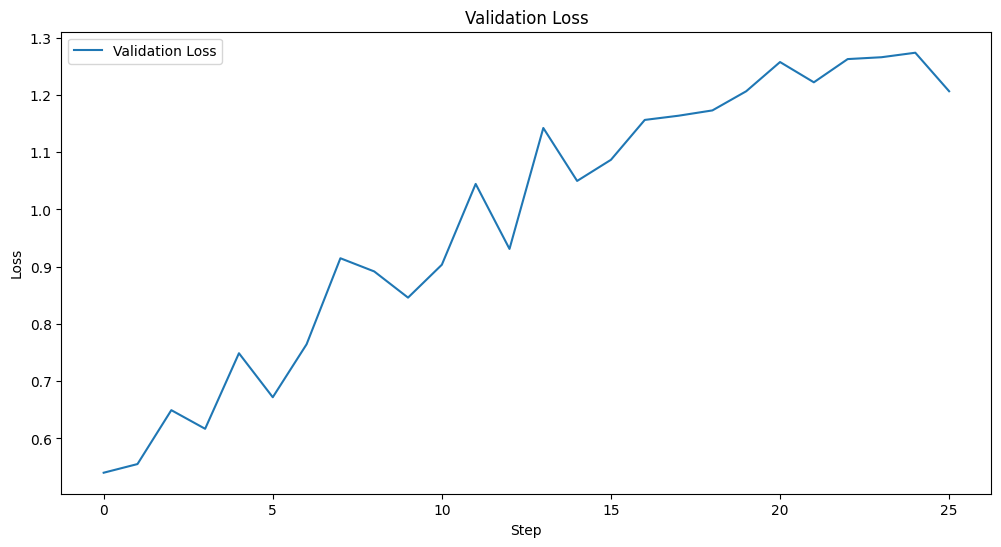

In [9]:
plot_eval_loss(trainer)

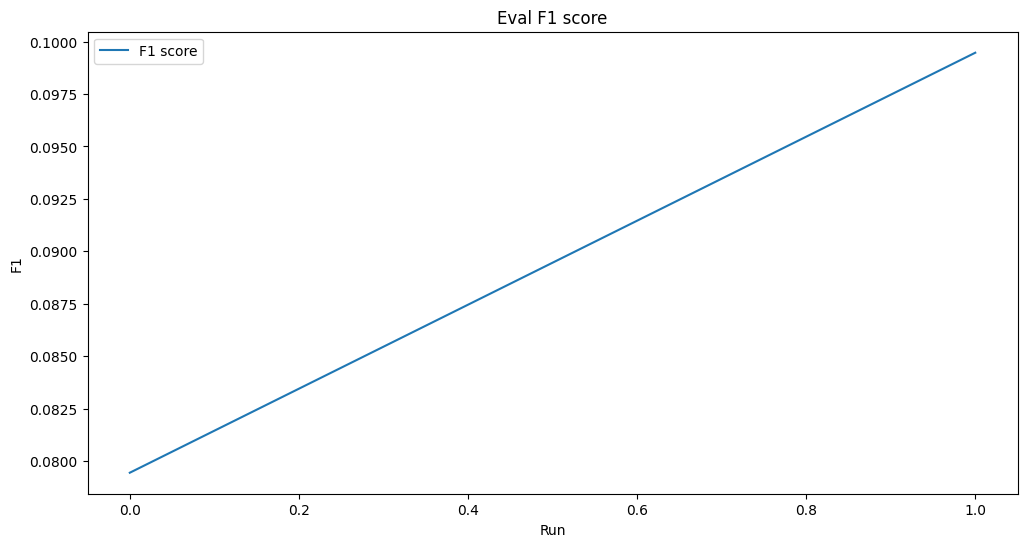

In [10]:
plot_model_progress(full_report)

5. Save weights

In [11]:
trainer.save_model(MODELS_FOLDER / "manipulation-detector-bert-ner-ru-model")
tokenizer.save_pretrained(MODELS_FOLDER / "manipulation-detector-bert-ner-ru-model")

('/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-ru-model/tokenizer_config.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-ru-model/special_tokens_map.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-ru-model/vocab.txt',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-ru-model/added_tokens.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-ru-model/tokenizer.json')

6. Test

In [12]:
model = AutoModelForTokenClassification.from_pretrained(
    MODELS_FOLDER / "manipulation-detector-bert-ner-ru-model"
)
tokenizer = AutoTokenizer.from_pretrained(
    MODELS_FOLDER / "manipulation-detector-bert-ner-ru-model"
)

In [13]:
test_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

test_result = test_pipeline(dataset["test"]["content"])

Device set to use mps:0


In [14]:
visualize_as_markdown_and_save(
    dataset["test"],
    test_result,
    tokenizer,
    REPORTS_FOLDER / "span-detection-ru" / "test-visualization" / f"test-{epoch_time}.md",
)

Dataset({
    features: ['id', 'content', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 164
})
